# Static magnetization equilibrium and hysteresis loops
In this example, we show how to use our `MacrospinEquilibrium` class to calculate static direction of magnetization in simple systems. The output can then be used in `SingleLayerNumeric` *(other classes don't work for partially OOP magnetization, yet)*. Eventually, it can also be used to calculate hysteresis loops or field-swept ferromagnetic resonance frequencies (`### make an example on the FMR sweep and reference it here`).

*Note: It is based on a single macrospin model, so do not expect it to be super exact for thick films, waveguides, etc.*

## Basic usage and application to `SingleLayer`

We start with importing the needed modules and simple system definition. By default, the class assumes a thin film in the laboratory frame of coordinates, i.e. *x,y* are in-plane (IP) of the film, *z* out-of-plane (OOP) (later we will also assume that spin waves propagate along *x*). We will now use the saturation magnetization of NiFe and apply magnetic field 40° from film normal.

In [1]:
# import modules
import numpy as np  # for vectorization
import matplotlib.pyplot as plt  # for plotting
import SpinWaveToolkit as SWT

In [2]:
# initiate the class
maceq = SWT.MacrospinEquilibrium(
    Ms=SWT.NiFe.Ms,  # saturation magnetization of built-in NiFe
    Bext=0.5,  # (T) external field
    theta_H=np.deg2rad(40),  # (rad) polar angle of external field
    phi_H=np.deg2rad(1e-4),  # (rad) azimuthal angle of external field
    # Without specifying `theta` and `phi`, the initial state of magnetization 
    # will be in the direction of the field.
)

You could notice the small angle of `phi_H`. This is because the model can get stuck, so slight "kick" around the exact value may help you reach the better results.

Now, to get the equilibrium angle we just use the `maceq.minimize()` method. The output is then stored in the `maceq.M` attribute as a dictionary.

In [3]:
maceq.minimize()
print(*[f"{key} = {maceq.M[key]:.3f} rad = {np.rad2deg(maceq.M[key]):.2f}°," 
        for key in maceq.M.keys()])

Minimum successfully found.
theta = 1.281 rad = 73.40°, phi = 0.000 rad = 0.00°,


You see, that the interplay between the demagnetization field and external field resulted in the static magnetization direction of about 73.4°. This can be now used for dispersion relation calculations. To do this, we will now just use the `maceq` object and built-in NiFe parameters.

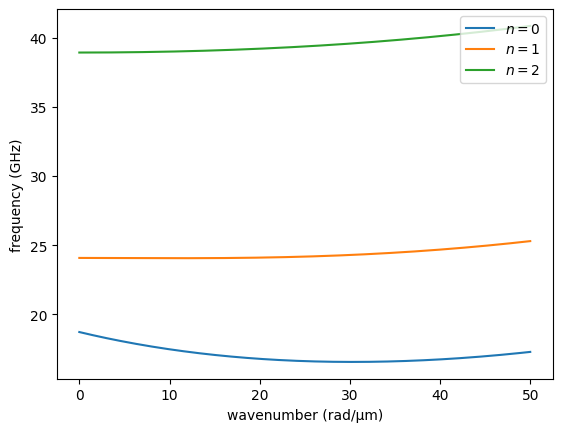

In [4]:
k = np.linspace(1, 50e6, 200)
sl = SWT.SingleLayer(material=SWT.NiFe, d=50e-9, kxi=k, **maceq.M, **maceq.Bext)

for i in range(3):
    plt.plot(k*1e-6, sl.GetDispersion(i)/(2e9*np.pi), "-", label=f"$n=${i}")
plt.xlabel("wavenumber (rad/µm)")
plt.ylabel("frequency (GHz)")
plt.legend(loc="upper right")
plt.show()

## Adding anisotropy
It is quite common to encounter magnetic systems with anisotropic behaviour. Here, we currently implement only uniaxial anisotropy, which can be set in any direction in the laboratory frame using the `theta` and `phi` angles. You can add as many anisotropies as you like, but one or two is usually enough. It is done by calling the `add_uniaxial_anisotropy()` method with `Ku > 0` for easy-axis and `Ku < 0` for easy plane. However, sometimes it is more useful to define the anisotropy using the anisotropy field `Bani`. In this case the `Ku` input is ignored in favor of the `Bani` parameter, which is recalculated to `Ku` internally.

In [5]:
maceq.add_uniaxial_anisotropy(
    name="anisotropy0",  # name to be used in the dictionary of anisotropies
    Ku=0, # (J/m^3) uniaxial anisotropy stength, here unused because we use Bani
    theta=np.pi/2,  # (rad) polar angle of anisotropy axis, here IP
    phi=0,  # (rad) azimuthal angle of anisotropy axis
    Bani=20e-3,  # (T) anisotropy field µ_0*H_ani
)

Now, you can either update the parameters of this anisotropy if you use the same name in this method or add another anisotropy with different name. All anisotropies are saved as a dictionary under the `maceq.anis` attribute with names being the dict keys. Each value is then another dictionary consisting of the set values of `Ku`, `theta`, `phi`, and a corresponding anisotropy tensor in the lab frame `Na`.

In [6]:
maceq.anis["anisotropy0"]

{'Ku': 8000.0,
 'theta': 1.5707963267948966,
 'phi': 0,
 'Na': array([[1.98943679e-02, 0.00000000e+00, 1.21817870e-18],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.21817870e-18, 0.00000000e+00, 7.45919322e-35]])}

The tensor is currently used for the energy evaluations and is calculated only when the method `add_uniaxial_anisotropy()` is called. Therefore to change the parameters, e.g. the theta angle, it is recommended to use rather the `add_uniaxial_anisotropy()` method instead of dictionary assignment.

## Hysteresis loops
With this macrospin model, we can also simulate hysteresis loops, similarly to e.g. the Stoner-Wohlfarth model.

So far we have created the system as a thin film with IP uniaxial anisotropy. To get the hysteresis loops, we will sweep the values of `maceq.Bext` dictionary and calculate a new equilibrium at each field value, while the starting value of magnetization direction will be the one calculated at the previous field point. We can either code this ourselves or use the built-in method `hysteresis()` of the `MacrospinEquilibrium` class.

We will illustrate this also while sweeping the IP angle of external field, changing from the easy-axis direction to the hard-axis direction.

[####################] 100.0 % | elapsed:   2.4 s | ETC:   0.0 s
[####################] 100.0 % | elapsed:   2.1 s | ETC:   0.0 s
[####################] 100.0 % | elapsed:   2.0 s | ETC:   0.0 s
[####################] 100.0 % | elapsed:   1.9 s | ETC:   0.0 s
[####################] 100.0 % | elapsed:   1.7 s | ETC:   0.0 s
[####################] 100.0 % | elapsed:   1.7 s | ETC:   0.0 s
[####################] 100.0 % | elapsed:   1.8 s | ETC:   0.0 s


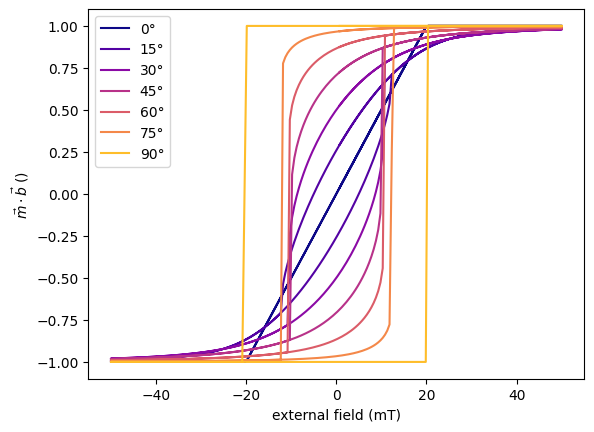

In [ ]:
nb, na = 200, 7  # number of field points and IP angle points
bexts = np.linspace(-0.05, 0.05, nb)  # field range vector
# now we use the range vector to create the full loop (0->max->min->max)
bexts = np.concatenate((bexts[nb//2+1:], -bexts, bexts))  
nb = len(bexts)  # ...and update the number of field points

btheta = np.deg2rad(90)+1e-5  # (rad) fixed value of field's theta
bphis_deg = np.linspace(0, 90, na)+1e-3  # (deg) sweep vector of IP angle
bphis = np.deg2rad(bphis_deg)  # same in radians

# We also need unit vectors of field to convert the magnetization components 
# to projections in the field direction.
bs = SWT.sphr2cart(btheta, bphis)

thetas, phis = np.zeros((na, nb)), np.zeros((na, nb))  # preallocate
for i in range(na):  # calculate loops at each `bphis`
    thetas[i], phis[i] = maceq.hysteresis(
        bexts, btheta, bphis[i], 
        # The default "Nelder-Mead" method usually works best, but it can be 
        # changed manually through the `scipy_kwargs` dirtionary.
        scipy_kwargs={"method": "L-BFGS-B"},
    )
ms = SWT.sphr2cart(thetas, phis)  # [mx, my, mz] unit magnetization components

cmap = plt.get_cmap("plasma")
for i in range(na):
    plt.plot(bexts*1e3, np.dot(bs[:, i], ms[:, i]), c=cmap(i/na), 
             label=f"{bphis_deg[i]:.0f}°")
plt.xlabel("external field (mT)")
plt.ylabel(r"$\vec{m} \cdot \vec{b}$ ()")
plt.legend(loc="upper left")
plt.show()

Ta da! Nice and easy.

Note that with the built-in method, we can sweep only external field parameters. To sweep something else, e.g. uniaxial anisotropy strength or direction, you need to code this yourself.